# Import Libraries

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Pre-processing
import missingno as mn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Simple Models
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Tree Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, balanced_accuracy_score, roc_curve, auc

# Preservation
import pickle


# Load Data

In [4]:
def load_data(level=3):
    weeks = list(range(1, 18))
    for week in weeks:
        path=f'./data/level_{level}/week_{week}.csv'
        data = pd.read_csv(path, compression='zip')

        yield data

In [18]:
data = load_data()
data = list(data)

In [19]:
data = pd.concat(data, ignore_index=True)

# Pre-processing

Select only offensive rows

In [20]:
data = data.loc[data['possession'] == 1]

Thats a lot of rows!

In [21]:
data.shape

(1526185, 36)

Check for missing values

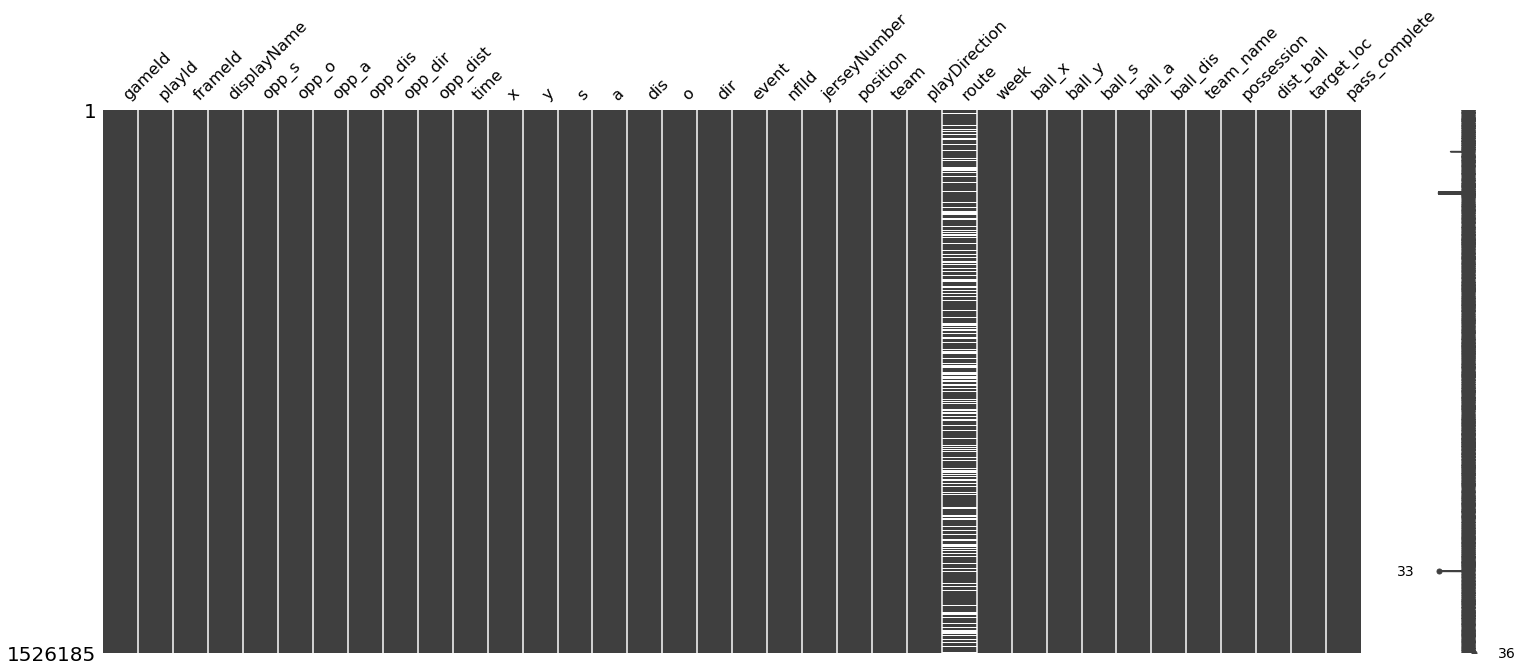

In [9]:
mn.matrix(data);

In [22]:
data.isna().sum()

gameId                0
playId                0
frameId               0
displayName           0
opp_s                 0
opp_o                25
opp_a                 0
opp_dis               0
opp_dir              24
opp_dist              0
time                  0
x                     0
y                     0
s                     0
a                     0
dis                   0
o                     6
dir                   6
event                 0
nflId                 0
jerseyNumber          0
position              0
team                  0
playDirection         0
route            424892
week                  0
ball_x                0
ball_y                0
ball_s                0
ball_a                6
ball_dis              0
team_name             0
possession            0
dist_ball             0
target_loc            0
pass_complete         0
dtype: int64

Impute missing values. Very few, in the grade scheme of things.

In [23]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data[['opp_o', 'opp_dir', 'o', 'dir', 'ball_a']] = imp_mean.fit_transform(data[['opp_o', 'opp_dir', 'o', 'dir', 'ball_a']])
data['route'].fillna('None', inplace=True)

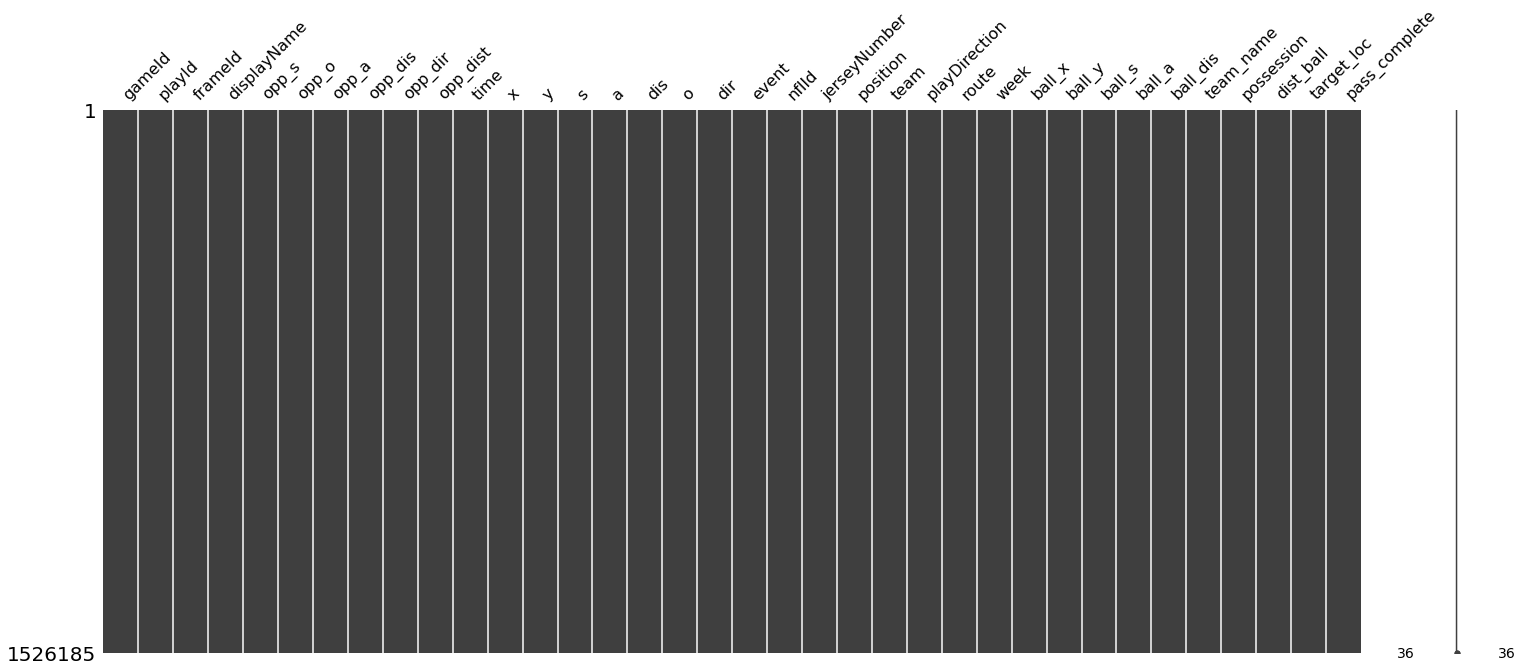

In [24]:
mn.matrix(data);

All missing values accounted for.

In [25]:
data.isna().sum().sum()

0

# Baseline Model

Feature selection

In [26]:
simple_features = ['dist_ball', 'x', 'y', 's', 'a', 'team']
X = data[(data['possession'] == 1) & (data['event'] == 'pass_forward') & (data['displayName'] == data['target_loc'])][simple_features].copy()
y = data[(data['possession'] == 1) & (data['event'] == 'pass_forward') & (data['displayName'] == data['target_loc'])]['pass_complete'].copy()

Clean a few dirty X coordinates

In [27]:
y = y[X['x'] >= 0]
X = X[X['x'] >= 0]

Baseline %

In [28]:
y.value_counts(normalize=True)

1    0.646892
0    0.353108
Name: pass_complete, dtype: float64

In [29]:
y.value_counts()

1    11177
0     6101
Name: pass_complete, dtype: int64

In [30]:
X['team'] = X['team'].map({'home': 1, 'away': 0})

In [31]:
X.shape

(17278, 6)

In [32]:
X.head()

,dist_ball,x,y,s,a,team
8,24.178662,80.69,44.91,3.11,6.67,0
250,11.622517,45.51,36.91,2.61,2.25,0
500,15.208001,51.83,13.69,4.58,2.44,0
694,23.477012,35.70,21.07,7.32,4.19,0
1029,13.595356,9.17,35.20,5.11,3.28,0


In [33]:
y.shape

(17278,)

In [34]:
y.head()

8       1
250     0
500     0
694     1
1029    0
Name: pass_complete, dtype: int64

### Train/Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Scale

In [36]:
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

### Model Score Helper Function

In [37]:
def score_all(X_tr, X_te, y_tr, y_te, clf):
    for l, c in clf.items():
        pred = c.predict(X_te)
        print(f"Train Accuracy: {np.round(accuracy_score(y_tr, c.predict(X_tr)),3)} ")
        print(f"Test Accuracy: {np.round(accuracy_score(y_te, pred), 3)} ")
        print(f"Train Bal Acc: {np.round(balanced_accuracy_score(y_tr, c.predict(X_tr)), 3)} ")
        print(f"Test Bal Acc: {np.round(balanced_accuracy_score(y_te, pred), 3)} ")
        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        ConfusionMatrixDisplay.from_predictions(y_te, pred, cmap='Blues', ax=ax[0])
        RocCurveDisplay.from_predictions(y_te, pred, ax=ax[1])
        fig.suptitle(l)
        plt.show()

## Baseline Model

In [38]:
np.round(y_test.value_counts(normalize=True),3)

1    0.647
0    0.353
Name: pass_complete, dtype: float64

Train Accuracy: 0.647 
Test Accuracy: 0.647 
Train Bal Acc: 0.5 
Test Bal Acc: 0.5 


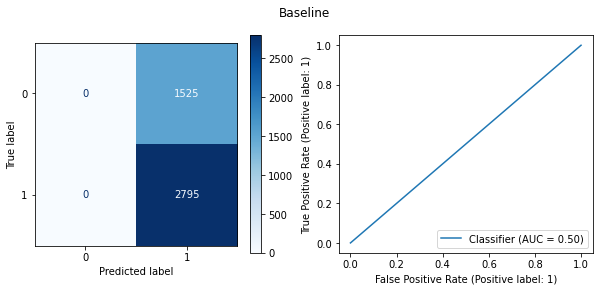

In [39]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
baseline = {'Baseline': dummy}
score_all(X_train_sc, X_test_sc, y_train, y_test, baseline)

Target to beat is 64.7% accuracy and 50% balanced accuracy. Given that our data has a 2/1 split balanced accuracy is slightly more important than standard accuracy. The best models will attempt to maximize both, with balanced accuracy being the tie breaker.

## Simple Models

A reminder, our features are as follows: ['dist_ball', 'x', 'y', 's', 'a', 'team']. Very basic, location of the player and if they are playing at home or on the road. Distance to ball will be used to determine the distance the ball needs to travel in the air.


In [40]:
# Logistic Regression
lr_param = {'C': [.5, 1, 5, 10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42, max_iter=10_000, n_jobs=-1), param_grid=lr_param, cv=5).fit(X_train_sc, y_train)
print('LR complete')

# Random Forest Classifier
rf_param = {'n_estimators': [500, 1000], 'min_samples_split': [25, 50], 'max_depth': [20, 50]}
rf = GridSearchCV(RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42), param_grid=rf_param, cv=5).fit(X_train_sc, y_train)
print('RF complete')

# Extra Trees Classifier
xt_param = {'n_estimators': [500, 1000], 'min_samples_split': [25, 50], 'max_depth': [20, 50]}
xt = GridSearchCV(ExtraTreesClassifier(n_jobs=-1, random_state=42, class_weight='balanced'), param_grid=xt_param, cv=5).fit(X_train_sc, y_train)
print('XT complete')

LR complete
RF complete
XT complete


It should be noted, Naive Bayes model did not perform well, so it was removed from the notebook.

In [41]:
print(lr.best_params_)
print(rf.best_params_)
print(xt.best_params_)

{'C': 0.5}
{'max_depth': 50, 'min_samples_split': 25, 'n_estimators': 1000}
{'max_depth': 20, 'min_samples_split': 25, 'n_estimators': 500}


Using a good balance of bias and variance in the model parameters. More estimators increases the bias, while allowing the trees to go deep increases the variance.

Train Accuracy: 0.567 
Test Accuracy: 0.575 
Train Bal Acc: 0.551 
Test Bal Acc: 0.557 


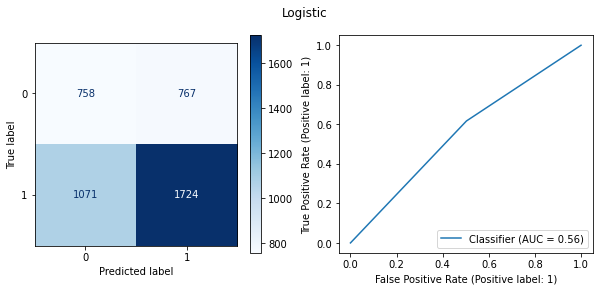

Train Accuracy: 0.899 
Test Accuracy: 0.648 
Train Bal Acc: 0.891 
Test Bal Acc: 0.595 


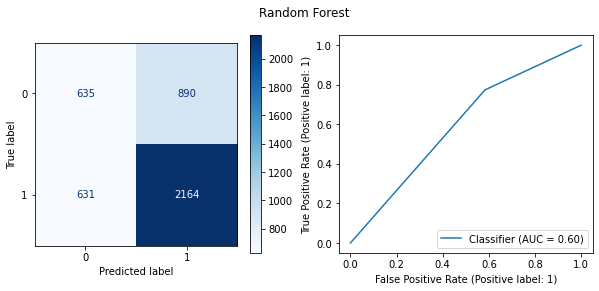

Train Accuracy: 0.814 
Test Accuracy: 0.636 
Train Bal Acc: 0.81 
Test Bal Acc: 0.607 


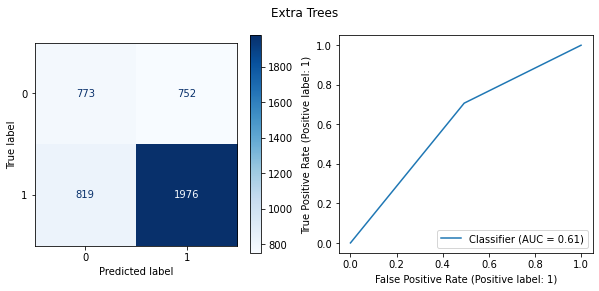

In [42]:
models = {
    'Logistic': lr,
    'Random Forest': rf,
    'Extra Trees': xt
}
score_all(X_train_sc, X_test_sc, y_train, y_test, clf=models)

Random Forest and Extra Trees appear to be returning the highest accuracy, but they are right at about baseline. Will see how engineering more features affects accuracy. Balanced accuracy is a little higher and the train/test scores a little closer for Extra Trees compared to Random Forest. But models are likely overfitting.

## Additional Features

In [43]:
features = ['dist_ball', 'x', 'y', 's', 'a', 'team', 'position', 'route', 'opp_dist', 'opp_s', 'opp_a']
X2 = data[(data['possession'] == 1) & (data['event'] == 'pass_forward') & (data['displayName'] == data['target_loc'])][features].copy()
y2 = data[(data['possession'] == 1) & (data['event'] == 'pass_forward') & (data['displayName'] == data['target_loc'])]['pass_complete'].copy()

Team, position, and route are categorical features that, I am assuming, will have some predictive value.

In [44]:
dummy_vars = pd.get_dummies(X2[['team', 'position', 'route']])
X2.drop(columns=['team', 'position', 'route'], inplace=True)
X2 = pd.concat([X2, dummy_vars], axis=1)
X2.reset_index(drop=True, inplace=True)
X2['x'] = X2['x'].map(lambda x: 0 if x<0 else x)
X2.head()

,dist_ball,x,y,s,a,opp_dist,opp_s,opp_a,team_away,team_home,...,route_GO,route_HITCH,route_IN,route_None,route_OUT,route_POST,route_SCREEN,route_SLANT,route_WHEEL,route_undefined
0,24.178662,80.69,44.91,3.11,6.67,4.160048,4.68,2.18,1,0,...,0,1,0,0,0,0,0,0,0,0
1,11.622517,45.51,36.91,2.61,2.25,4.243230,5.36,2.25,1,0,...,0,1,0,0,0,0,0,0,0,0
2,15.208001,51.83,13.69,4.58,2.44,5.338352,4.14,2.80,1,0,...,0,0,0,0,0,0,1,0,0,0
3,23.477012,35.70,21.07,7.32,4.19,4.243218,1.14,4.50,1,0,...,0,0,0,0,0,0,0,0,0,0
4,13.595356,9.17,35.20,5.11,3.28,2.124382,2.65,3.15,1,0,...,0,0,0,0,1,0,0,0,0,0


## Tran/Test Split

In [45]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, random_state=42)

In [46]:
sc = StandardScaler()
sc.fit(X_train2)
X_train2_sc = sc.transform(X_train2)
X_test2_sc = sc.transform(X_test2)

Baseline reminder

In [47]:
y2.value_counts(normalize=True)

1    0.646892
0    0.353108
Name: pass_complete, dtype: float64

Grid searching with cross validation.

## Logistic Regression & Decision Trees

In [48]:
lr2_param = {'C': [1, 3, 5, 7]}
lr2 = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42, max_iter=10_000, n_jobs=-1), param_grid=lr2_param, cv=5).fit(X_train2_sc, y_train2)
print('LR complete')
rf2_param = {'n_estimators': [100, 500, 750], 'min_samples_split': [25, 50], 'max_depth': [50, 75]}
rf2 = GridSearchCV(RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42), param_grid=rf2_param, cv=5).fit(X_train2_sc, y_train2)
print('RF complete')
xt2_param = {'n_estimators': [100, 500, 750], 'min_samples_split': [25, 50], 'max_depth': [50, 75]}
xt2 = GridSearchCV(ExtraTreesClassifier(n_jobs=-1, random_state=42, class_weight='balanced'), param_grid=xt2_param, cv=5).fit(X_train2_sc, y_train2)
print('XT complete')

LR complete
RF complete
XT complete


In [49]:
print(lr2.best_params_)
print(rf2.best_params_)
print(xt2.best_params_)

{'C': 5}
{'max_depth': 50, 'min_samples_split': 25, 'n_estimators': 750}
{'max_depth': 50, 'min_samples_split': 25, 'n_estimators': 750}


Models like the additional bias.

Train Accuracy: 0.613 
Test Accuracy: 0.619 
Train Bal Acc: 0.61 
Test Bal Acc: 0.62 


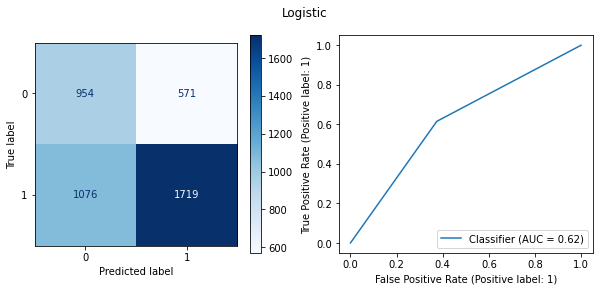

Train Accuracy: 0.888 
Test Accuracy: 0.687 
Train Bal Acc: 0.88 
Test Bal Acc: 0.647 


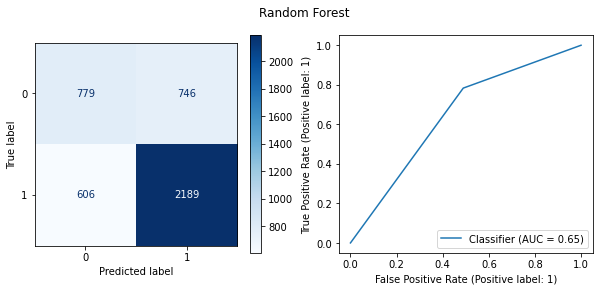

Train Accuracy: 0.835 
Test Accuracy: 0.67 
Train Bal Acc: 0.835 
Test Bal Acc: 0.647 


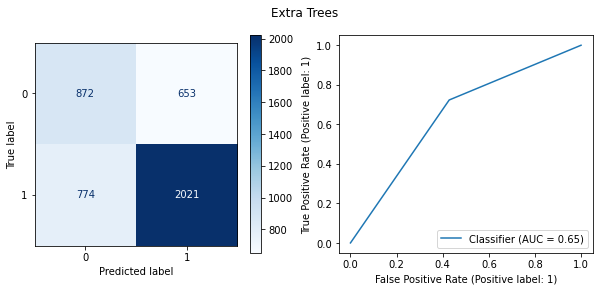

In [50]:
models2 = {
    'Logistic': lr2,
    'Random Forest': rf2,
    'Extra Trees': xt2
}
score_all(X_train2_sc, X_test2_sc, y_train2, y_test2, clf=models2)

All 3 models showed an improvement in accuracy and balanced accuracy. Baseline accuracy was 64.7, with a balanced accuracy score of 50.0. Random forest improves to 68.7 & 64.7 respectively. An improvement of 4% and 14.7% to both of our accuracy metrics. An area under the curve of 65% will be the new baseline score to top with a Neural Network.

Time to advance into the deep learning space. Lets see how the model's adjust.

## Deep Learning

Start with the same model features.

In [207]:
# X3_features = ['dist_ball', 'x', 'y', 's', 'a', 'opp_dist', 'opp_s', 'opp_a', 'team', 'position', 'route']
X3_features = ['dist_ball', 'x', 'y', 's', 'a', 'opp_dist', 'opp_s', 'opp_a', 'route']
# X3_features = ['dist_ball', 'x', 'y', 's', 'opp_dist', 'opp_s']                                                       # 68.0 
# X3_features = ['dist_ball', 's', 'a', 'opp_s', 'opp_a', 'opp_dist']                                                   # 66.8


X3 = data[(data['possession'] == 1) & (data['event'] == 'pass_forward') & (data['displayName'] == data['target_loc'])][X3_features].copy()
y3 = data[(data['possession'] == 1) & (data['event'] == 'pass_forward') & (data['displayName'] == data['target_loc'])]['pass_complete'].copy()

# dummy_vars = pd.get_dummies(X3[['team', 'position', 'route']])
dummy_vars = pd.get_dummies(X3[['route']])
# X3.drop(columns=['team', 'position', 'route'], inplace=True)
X3.drop(columns=['route'], inplace=True)
X3 = pd.concat([X3, dummy_vars], axis=1)

X3['x'] = X3['x'].map(lambda x: 0 if x<0 else x)

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify=y3, random_state=42)

sc = StandardScaler()
sc.fit(X_train3)
X_train3_sc = sc.transform(X_train3)
X_test3_sc = sc.transform(X_test3)

Helper function to aid in model testing

In [221]:
def fit_model(clfs):
    clf_log = {}
    for i, clf in enumerate(clfs):

        early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=10,
        verbose=1,
        )

        history = clf.fit(
        X_train3_sc,
        y_train3,
        batch_size=2056,
        epochs=200,
        validation_data=(X_test3_sc, y_test3),
        callbacks=early_stop,
        verbose=0
        )

        print(clf.evaluate(X_test3_sc, y_test3))

        # plt.plot(history.history['val_accuracy'], label='Validation Accuracy');
        # plt.plot(history.history['accuracy'], label='Training Accuracy');
        # plt.legend()
        # plt.show();

        pred = clf.predict(X_test3_sc)

        acc_score = np.round(accuracy_score(y_test3, np.where(pred.flatten() >= .5, 1, 0)) * 100, 1)
        bal_acc = np.round(balanced_accuracy_score(y_test3, np.where(pred.flatten() >= .5, 1, 0)) * 100, 1)
        # print("Neural Net Score:")
        # print(f'Accuracy: {acc_score}')
        # print(f'Balanced Accuracy: {bal_acc}')
        
        fpr, tpr, thresholds = roc_curve(y_test3, pred.flatten())
        roc_auc = np.round(auc(fpr, tpr) * 100, 1)

        # RocCurveDisplay.from_predictions(y_test3, pred.flatten());
        # plt.show()

        # ConfusionMatrixDisplay.from_predictions(y_test3, np.where(pred.flatten() >= .5, 1, 0), cmap='Blues')
        # plt.show()

        clf_log[i] = {'acc': acc_score, 'bal_acc': bal_acc, 'auc': roc_auc}

    return clf_log

        

## Neural Networks

Will test a few network architectures at the same time.

In [209]:
model_0 = Sequential()
model_0.add(Dense(800, activation='relu'))
model_0.add(Dropout(.225))
model_0.add(Dense(800, activation='relu'))
model_0.add(Dropout(.225))
model_0.add(Dense(800, activation='relu'))
model_0.add(Dropout(.225))
model_0.add(Dense(1, activation='sigmoid'))

model_0.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)


In [210]:
model_1 = Sequential()
model_1.add(Dense(800, activation='relu'))
model_1.add(Dropout(.225))
model_1.add(Dense(800, activation='relu'))
model_1.add(Dropout(.225))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [211]:
model_2 = Sequential()
model_2.add(Dense(400, activation='relu'))
model_2.add(Dropout(.225))
model_2.add(Dense(400, activation='relu'))
model_2.add(Dropout(.225))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [212]:
model_3 = Sequential()
model_3.add(Dense(200, activation='relu'))
model_3.add(Dropout(.225))
model_3.add(Dense(200, activation='relu'))
model_3.add(Dropout(.225))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [213]:
model_4 = Sequential()
model_4.add(Dense(100, activation='relu'))
model_4.add(Dropout(.225))
model_4.add(Dense(100, activation='relu'))
model_4.add(Dropout(.225))
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [214]:
model_5 = Sequential()
model_5.add(Dense(100, activation='relu'))
model_5.add(Dropout(.3))
model_5.add(Dense(100, activation='relu'))
model_5.add(Dropout(.3))
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [215]:
model_6 = Sequential()
model_6.add(Dense(100, activation='relu'))
model_6.add(Dropout(.4))
model_6.add(Dense(100, activation='relu'))
model_6.add(Dropout(.4))
model_6.add(Dense(1, activation='sigmoid'))

model_6.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [216]:
model_7 = Sequential()
model_7.add(Dense(50, activation='relu'))
model_7.add(Dropout(.4))
model_7.add(Dense(50, activation='relu'))
model_7.add(Dropout(.4))
model_7.add(Dense(1, activation='sigmoid'))

model_7.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [217]:
model_8 = Sequential()
model_8.add(Dense(200, activation='relu'))
model_8.add(Dropout(.5))
model_8.add(Dense(200, activation='relu'))
model_8.add(Dropout(.5))
model_8.add(Dense(1, activation='sigmoid'))

model_8.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [218]:
model_9 = Sequential()
model_9.add(Dense(200, activation='relu'))
model_9.add(Dropout(.5))
model_9.add(Dense(200, activation='relu'))
model_9.add(Dropout(.5))
model_9.add(Dense(200, activation='relu'))
model_9.add(Dropout(.5))
model_9.add(Dense(1, activation='sigmoid'))

model_9.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [219]:
model_10 = Sequential()
model_10.add(Dense(300, activation='relu', 
                    kernel_regularizer=l2(.0025)))
model_10.add(Dropout(.4))
model_10.add(Dense(300, activation='relu', 
                    kernel_regularizer=l2(.001)))
model_10.add(Dense(1, activation='sigmoid'))

model_10.compile(
    optimizer='adam',
    loss='bce',
    metrics=['accuracy']
)

In [ ]:
models = [model_0, model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8, model_9, model_10]
results = fit_model(models)
results

Log of model results

Feature Set 1 \
['dist_ball', 'x', 'y', 's', 'a', 'opp_dist', 'opp_s', 'opp_a', 'team', 'position', 'route']
| Model ID | Accuracy Score | Balanced Accuracy | Area Under the Curve |
| ------ | ---------- | ------------- | -------------- |
| model 0 | 70.2% | 61.7% | 70% |
| model 1 | 69.9% | 61.4% | 71% |
| model 2 | 69.7% | 61.8% | 71% |
| model 3 | 70.2% | 62.0% | 71% |
| model 4 | 69.8% | 60.8% | 71% | 
| model 5 | 69.6% | 60.3% | 71% | 
| model 6 | 69.3% | 59.5% | 71% |
| model 7 | 69.5%% | 59.6% | 71% | 
| model 8 | 69.6% | 60.0% | 71% | 
| model 9 | 69.4% | 59.9% | 70% | 
| model 10 | 69.6% | 61.7% | 71% |

<b>Feature Set 2:</b> \
<b>['dist_ball', 'x', 'y', 's', 'a', 'opp_dist', 'opp_s', 'opp_a', 'route'] </b>
| Model ID | Accuracy Score | Balanced Accuracy | Area Under the Curve |
| ------ | ---------- | ------------- | -------------- |
| model 0 | 70.0% | 60.7% | 70.7% |
| model 1 | 69.8% | 60.5% | 70.6% |
| model 2 | 70.3% | 61.9% | 70.6% |
| model 3 | 69.7% | 60.9% | 70.6% |
| model 4 | 69.9% | 61.0% | 70.6% |
| model 5 | 70.0% | 61.0% | 70.8% |
| model 6 | 69.3% | 59.7% | 70.4% |
| model 7 | 69.1% | 58.8% | 70.5% |
| model 8 | 69.8% | 60.5% | 70.9% |
| model 9 | 69.0% | 59.1% | 70.4% |
| <b>model 10<b> | <b>70.0%<b> | <b>61.3%<b> | <b>70.8%<b> |

Feature Set 3: \
['dist_ball', 'x', 'y', 's', 'opp_dist', 'opp_s']
| Model ID | Accuracy Score | Balanced Accuracy | Area Under the Curve |
| ------ | ---------- | ------------- | -------------- |
| model 0 | 68.8% | 59.7% | 68.5% |
| model 1 | 69.2% | 60.6% | 68.6% |
| model 2 | 69.2% | 60.2% | 68.6% |
| model 3 | 69.2% | 59.5% | 68.6% |
| model 4 | 69.1% | 59.9% | 68.4% |
| model 5 | 69.0% | 58.9% | 68.4% |
| model 6 | 68.8% | 58.7% | 68.4% |
| model 7 | 68.6% | 58.2% | 68.1% |
| model 8 | 68.9% | 58.7% | 68.4% |
| model 9 | 68.6% | 58.2% | 68.2% |
| model 10 | 68.8% | 59.4% | 68.3% |

Feature Set 4: \
['dist_ball', 's', 'a', 'opp_s', 'opp_a', 'opp_dist']
| Model ID | Accuracy Score | Balanced Accuracy | Area Under the Curve |
| ------ | ---------- | ------------- | -------------- |
| model 0 | 68.4% | 60.0% | 67.8% |
| model 1 | 68.2% | 59.9% | 67.8% |
| model 2 | 68.4% | 59.6% | 68.1% |
| model 3 | 68.2% | 59.1% | 68.1% |
| model 4 | 68.2% | 58.5% | 68.0% |
| model 5 | 68.3% | 58.8% | 68.1% |
| model 6 | 68.5% | 59.3% | 68.1% |
| model 7 | 68.1% | 58.5% | 67.8% |
| model 8 | 68.3% | 58.7% | 68.2% |
| model 9 | 68.4% | 59.1% | 68.0% |
| model 10 | 68.2% | 58.8% | 67.8% |

Feature set 2 with model 10 is the best of all the model structures/features tested. Will now use the same features to test the decision tree models. When all the models have been rebuilt, I will use an ensemble classifier in an attempt to improve model performace more.

## Rebuilding Classifiers

Rebuild logistic regression and decision tree models using the same features as the neural networks.

In [270]:
rf6_param = {'n_estimators': [1000], 'min_samples_split': [5], 'max_depth': [9]}
rf6 = GridSearchCV(RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', random_state=42), param_grid=rf6_param, cv=5).fit(X_train3_sc, y_train3)
print('RF complete')
xt5_param = {'n_estimators': [2500], 'min_samples_split': [5], 'max_depth': [17]}
xt5 = GridSearchCV(ExtraTreesClassifier(n_jobs=-1, random_state=42, class_weight='balanced_subsample'), param_grid=xt5_param, cv=5).fit(X_train3_sc, y_train3)
print('XT complete')

RF complete
XT complete


In [271]:
print(rf6.best_params_)
print(xt5.best_params_)

{'max_depth': 9, 'min_samples_split': 5, 'n_estimators': 1000}
{'max_depth': 17, 'min_samples_split': 5, 'n_estimators': 2500}


Train Accuracy: 0.746 
Test Accuracy: 0.671 
Train Bal Acc: 0.734 
Test Bal Acc: 0.65 


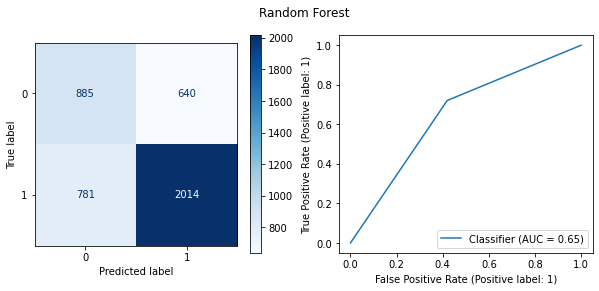

Train Accuracy: 0.896 
Test Accuracy: 0.669 
Train Bal Acc: 0.893 
Test Bal Acc: 0.643 


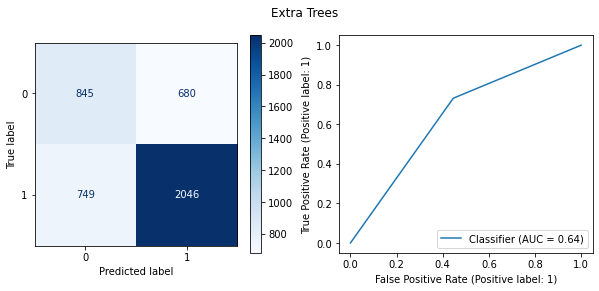

In [272]:
models5 = {
    'Random Forest': rf6,
    'Extra Trees': xt5
}
score_all(X_train3_sc, X_test3_sc, y_train3, y_test3, clf=models5)

## Ensemble Models

In [289]:
ens_models = {
    'Random Forest': rf6.best_estimator_,
    'Extra Trees': xt5.best_estimator_,
    'Neural Net': model_10
}

In [297]:
def ens_tune(models):

    # Neural Net
    nn_pred = models['Neural Net'].predict(X_test3_sc)
    nn_pred = nn_pred.flatten()

    print("Neural Net Score:")
    print(f'Accuracy: {np.round(accuracy_score(y_test3, np.where(nn_pred >= .55, 1, 0)) * 100, 1)}')
    print(f'Balanced Accuracy: {np.round(balanced_accuracy_score(y_test3, np.where(nn_pred >= .55, 1, 0)) * 100, 1)}')
    fig1, ax1 = plt.subplots(1, 2, figsize=(10,4))
    ConfusionMatrixDisplay.from_predictions(y_test3, np.where(nn_pred >= .55, 1, 0), cmap='Blues', ax=ax1[0])
    RocCurveDisplay.from_predictions(y_test3, nn_pred, ax=ax1[1])
    fig1.suptitle("Neural Net")
    plt.show()

    # Random Forest
    rf_pred = models['Random Forest'].predict_proba(X_test3_sc)[:,1]

    print("Random Forest Score:")
    print(f'Accuracy: {np.round(accuracy_score(y_test3, np.where(rf_pred >= .5, 1, 0)) * 100, 1)}')
    print(f'Balanced Accuracy: {np.round(balanced_accuracy_score(y_test3, np.where(rf_pred >= .5, 1, 0)) * 100, 1)}')
    fig2, ax2 = plt.subplots(1, 2, figsize=(10,4))
    ConfusionMatrixDisplay.from_predictions(y_test3, np.where(rf_pred >= .5, 1, 0), cmap='Blues', ax=ax2[0])
    RocCurveDisplay.from_predictions(y_test3, rf_pred, ax=ax2[1])
    fig2.suptitle("Random Forest")
    plt.show()

    # Extra Trees
    xt_pred = models['Extra Trees'].predict_proba(X_test3_sc)[:,1]

    print("Extra Trees Score:")
    print(f'Accuracy: {np.round(accuracy_score(y_test3, np.where(xt_pred >= .5, 1, 0)) * 100, 1)}')
    print(f'Balanced Accuracy: {np.round(balanced_accuracy_score(y_test3, np.where(xt_pred >= .5, 1, 0)) * 100, 1)}')
    fig3, ax3 = plt.subplots(1, 2, figsize=(10,4))
    ConfusionMatrixDisplay.from_predictions(y_test3, np.where(xt_pred >= .5, 1, 0), cmap='Blues', ax=ax3[0])
    RocCurveDisplay.from_predictions(y_test3, xt_pred, ax=ax3[1])
    fig3.suptitle("Extra Trees")
    plt.show()


    ensemble_preds = pd.concat([
    pd.DataFrame(rf_pred),
    pd.DataFrame(xt_pred),
    pd.DataFrame(nn_pred),
    ], axis=1).mean(axis=1)

    print("Ensemble Score:")
    print(f'Accuracy: {np.round(accuracy_score(y_test3, np.where(ensemble_preds >= .52, 1, 0)) * 100, 1)}')
    print(f'Balanced Accuracy: {np.round(balanced_accuracy_score(y_test3, np.where(ensemble_preds >= .52, 1, 0)) * 100, 1)}')
    fig4, ax4 = plt.subplots(1, 2, figsize=(10,4))
    ConfusionMatrixDisplay.from_predictions(y_test3, np.where(ensemble_preds >= .52, 1, 0), cmap='Blues', ax=ax4[0])
    RocCurveDisplay.from_predictions(y_test3, ensemble_preds, ax=ax4[1])
    fig4.suptitle("Ensemble")
    plt.show()

Neural Net Score:
Accuracy: 69.9
Balanced Accuracy: 63.7


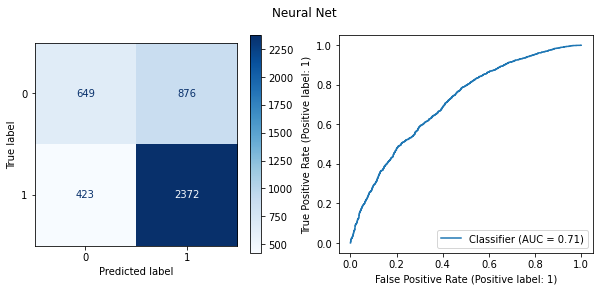

Random Forest Score:
Accuracy: 67.1
Balanced Accuracy: 65.0


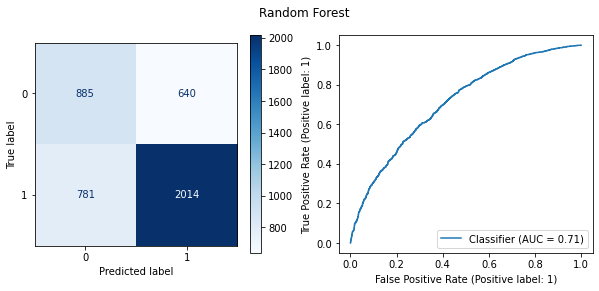

Extra Trees Score:
Accuracy: 66.9
Balanced Accuracy: 64.3


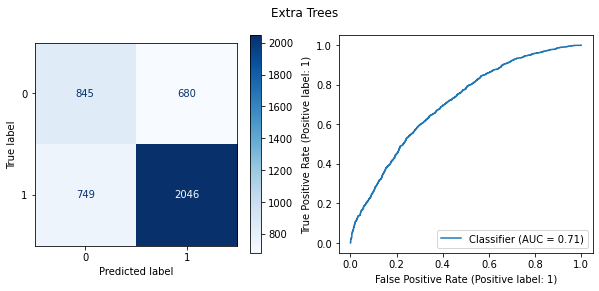

Ensemble Score:
Accuracy: 69.0
Balanced Accuracy: 65.3


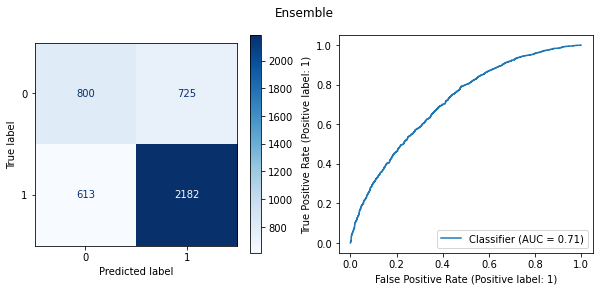

In [298]:
ens_tune(ens_models)

Balanced accuracy is the highest at 65.3% when combining random forest, extra trees, and a neural network with high regularization.

Preservation

In [300]:
path = './models/random_forest.pkl'
with open(path, 'wb') as f:
    pickle.dump(rf6, f)

In [301]:
path = './models/extra_trees.pkl'
with open(path, 'wb') as f:
    pickle.dump(xt5, f)

In [302]:
model_10.save('./models/neural_net.keras')

In [303]:
path = './models/scaler.pkl'
with open(path, 'wb') as f:
    pickle.dump(sc, f)

In [304]:
path = './models/features.pkl'
with open(path, 'wb') as f:
    pickle.dump(['dist_ball', 'x', 'y', 's', 'a', 'opp_dist', 'opp_s', 'opp_a', 'route'], f)